# Importowanie bibliotek

In [2]:
print("Importowanie bibliotek...")
import numpy as np
import pandas as pd
from scipy.io import loadmat
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
print("Biblioteki zaimportowane.")

Importowanie bibliotek...
Biblioteki zaimportowane.


# Wczytanie i przetworzanie danych

In [13]:
print("Wczytywanie i przetwarzanie danych...")
mat = loadmat('cars_annos.mat')
print("Pierwsze 5 rekordów z pliku mat:", mat['annotations'][:5])

annotations = mat['annotations']
annotations = annotations[0]
records = []
for annotation in annotations:
    records.append((annotation[0][0], annotation[5][0][0], annotation[6][0][0]))
df = pd.DataFrame.from_records(records, columns=['file', 'label', 'test'])
print("Pierwsze 5 rekordów z DataFrame:")
print(df.head())

train_df = df[df['test'] == 0].copy()
test_df = df[df['test'] == 1].copy()
train_df['file'] = train_df['file'].apply(lambda x: 'cars_train/cars_train/' + x.split('/')[-1].split('.')[0].zfill(5) + '.jpg')
test_df['file'] = test_df['file'].apply(lambda x: 'cars_test/cars_test/' + x.split('/')[-1].split('.')[0].zfill(5) + '.jpg')
print(test_df['file'])
print(f"Liczba próbek treningowych: {len(train_df)}, Liczba próbek testowych: {len(test_df)}")

Wczytywanie i przetwarzanie danych...
Pierwsze 5 rekordów z pliku mat: [[(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8))
  (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8))
  (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8))
  ...
  (array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dtype=uint16), array([[196]], dtype=uint8), array([[1]], dtype=uint8))
  (array(['car_ims/016184.jpg'], dtype='<U18'), array

# Augmentacja danych

In [16]:
print("Inicjalizacja generatora danych i augmentacja...")

# Dodanie odpowiednich ścieżek i konwersja numerów na format pięciocyfrowy
train_df['file'] = train_df['file'].apply(lambda x: 'cars_train/cars_train/' + x.split('/')[-1].split('.')[0].zfill(5) + '.jpg')
test_df['file'] = test_df['file'].apply(lambda x: 'cars_test/cars_test/' + x.split('/')[-1].split('.')[0].zfill(5) + '.jpg')

# Konwersja etykiet na typ string, aby uniknąć błędów
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# Inicjalizacja generatora danych
datagen = ImageDataGenerator(rescale=1./255)

# Augmentacja danych
train_data = datagen.flow_from_dataframe(train_df, directory=None, x_col='file', y_col='label', target_size=(224, 224), batch_size=32, class_mode='sparse')
test_data = datagen.flow_from_dataframe(test_df, directory=None, x_col='file', y_col='label', target_size=(224, 224), batch_size=32, class_mode='sparse')

print("Augmentacja danych zakończona.")

Inicjalizacja generatora danych i augmentacja...
Found 4114 validated image filenames belonging to 100 classes.


C:\ProgramData\Anaconda3\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 4030 invalid image filename(s) in x_col="file". These filename(s) will be ignored.
  warnings.warn(


Found 3989 validated image filenames belonging to 98 classes.
Augmentacja danych zakończona.


C:\ProgramData\Anaconda3\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 4052 invalid image filename(s) in x_col="file". These filename(s) will be ignored.
  warnings.warn(


# Inicjalizacja modelu sieci neuronowej

In [19]:
print("Inicjalizacja modelu...")

# Inicjalizacja modelu
model = Sequential()

# Dodanie warstw konwolucyjnych, poolingowych i w pełni połączonych
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(196))  # 196 klas
model.add(Activation('softmax'))

# Kompilacja modelu
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print("Model zainicjalizowany.")

Inicjalizacja modelu...
Model zainicjalizowany.


# Trenowanie modelu

In [20]:
# Parametry treningu
epochs = 50
steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

print(f"Rozpoczynam trening modelu na {epochs} epokach.")
print(f"Liczba kroków na epokę: {steps_per_epoch}")
print(f"Liczba kroków walidacji: {validation_steps}")

# Trenowanie modelu
history = model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_data,
    validation_steps=validation_steps
)

print("Trening modelu zakończony.")

Rozpoczynam trening modelu na 50 epokach.
Liczba kroków na epokę: 128
Liczba kroków walidacji: 124
Epoch 1/50
128/128 [==============================] - 88s 684ms/step - loss: 5.0553 - accuracy: 0.0088 - val_loss: 4.7917 - val_accuracy: 0.0106
Epoch 2/50
128/128 [==============================] - 87s 676ms/step - loss: 4.7732 - accuracy: 0.0073 - val_loss: 4.6631 - val_accuracy: 0.0106
Epoch 3/50
128/128 [==============================] - 83s 648ms/step - loss: 4.7127 - accuracy: 0.0096 - val_loss: 4.6394 - val_accuracy: 0.0055
Epoch 4/50
128/128 [==============================] - 88s 692ms/step - loss: 4.6700 - accuracy: 0.0110 - val_loss: 4.6313 - val_accuracy: 0.0086
Epoch 5/50
128/128 [==============================] - 83s 647ms/step - loss: 4.5821 - accuracy: 0.0167 - val_loss: 4.6529 - val_accuracy: 0.0088
Epoch 6/50
128/128 [==============================] - 83s 651ms/step - loss: 4.4282 - accuracy: 0.0416 - val_loss: 4.6702 - val_accuracy: 0.0121
Epoch 7/50
128/128 [===========

# Wizualizacja wyników

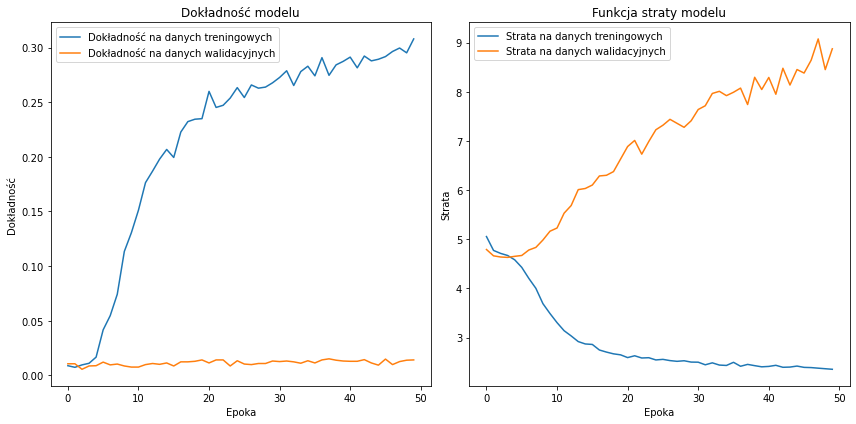

In [21]:
import matplotlib.pyplot as plt

# Wykres dokładności
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Dokładność na danych treningowych')
plt.plot(history.history['val_accuracy'], label='Dokładność na danych walidacyjnych')
plt.title('Dokładność modelu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

# Wykres funkcji straty
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Strata na danych treningowych')
plt.plot(history.history['val_loss'], label='Strata na danych walidacyjnych')
plt.title('Funkcja straty modelu')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Ocena modelu na danych testowych
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Strata na zbiorze testowym: {test_loss}")
print(f"Dokładność na zbiorze testowym: {test_accuracy}")

# Zapisanie modelu
model.save('my_model.h5')
print("Model został zapisany.")

125/125 [==============================] - 17s 137ms/step - loss: 8.8733 - accuracy: 0.0140
Strata na zbiorze testowym: 8.873348236083984
Dokładność na zbiorze testowym: 0.01403860654681921
Model został zapisany.


1/1 [==============================] - 0s 20ms/step
Losowy obrazek testowy: cars_test/cars_test/03693.jpg
Przewidywana klasa: 94
Prawdziwa klasa: 40


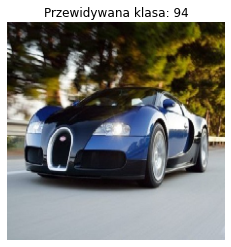

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import keras.utils as image

# Wybieranie losowego indeksu z danych testowych
random_idx = np.random.randint(0, len(test_data.filenames))

# Wczytywanie i przetwarzanie obrazu
img_path = test_data.filepaths[random_idx]
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

# Normalizacja obrazu (jeśli używana była w modelu)
img_batch /= 255.

# Predykcja klasy
predictions = model.predict(img_batch)
predicted_class = np.argmax(predictions[0])

# Wypisanie wyników
print(f"Losowy obrazek testowy: {img_path}")
print(f"Przewidywana klasa: {predicted_class}")
print(f"Prawdziwa klasa: {test_data.classes[random_idx]}")

# Wyświetlenie obrazka
plt.imshow(img)
plt.title(f"Przewidywana klasa: {predicted_class}")
plt.axis('off')
plt.show()

Train images paths: 404    cars_train/cars_train/00405.jpg
405    cars_train/cars_train/00406.jpg
406    cars_train/cars_train/00407.jpg
Name: file, dtype: object
Test images paths: 449    cars_test/cars_test/00450.jpg
450    cars_test/cars_test/00451.jpg
451    cars_test/cars_test/00452.jpg
Name: file, dtype: object


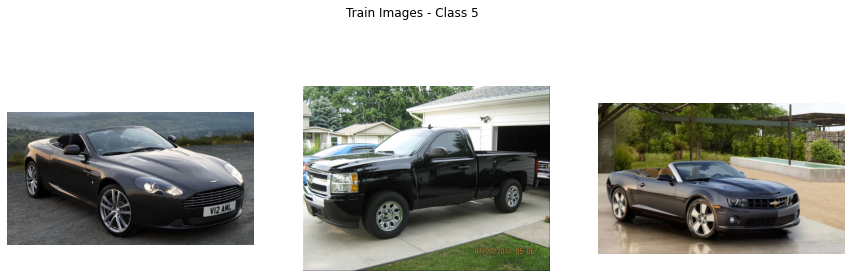

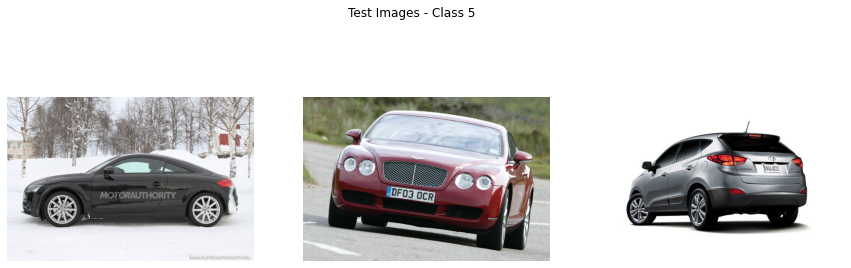

In [32]:
import matplotlib.pyplot as plt
import cv2

# Filtruj DataFrame, aby znaleźć obrazy z klasy 5
train_class_5 = train_df[train_df['label'] == '6']
test_class_5 = test_df[test_df['label'] == '6']

# Wybierz pierwsze 3 obrazy z każdego zestawu danych
train_images_5 = train_class_5['file'].iloc[:3]
test_images_5 = test_class_5['file'].iloc[:3]

print("Train images paths:", train_images_5)
print("Test images paths:", test_images_5)

# Funkcja do wyświetlania obrazów
def display_images(image_paths, title):
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, 3, i+1)
            plt.imshow(img)
            plt.axis('off')
        else:
            print(f"Image at {img_path} could not be loaded.")
    plt.suptitle(title)
    plt.show()

# Wyświetl obrazy
display_images(train_images_5, 'Train Images - Class 5')
display_images(test_images_5, 'Test Images - Class 5')


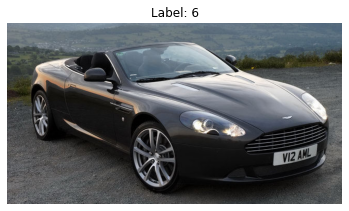

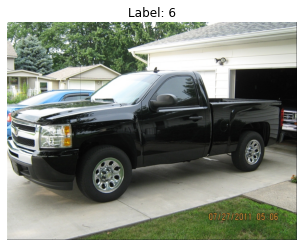

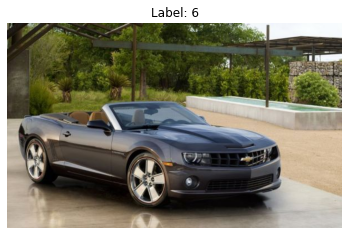

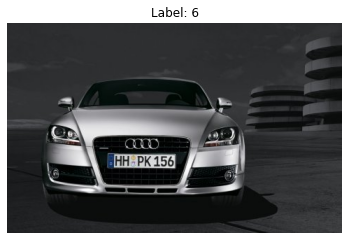

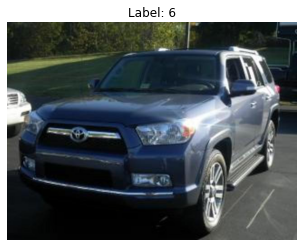

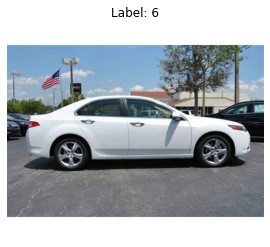

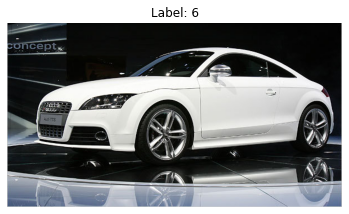

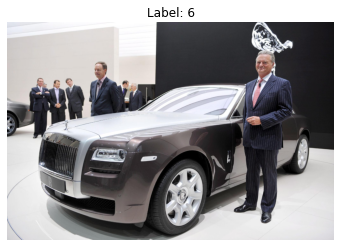

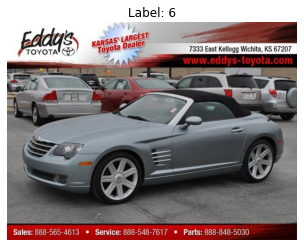

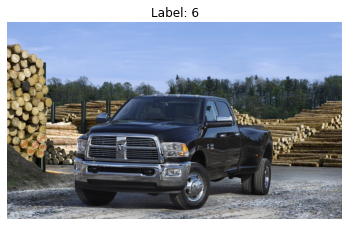

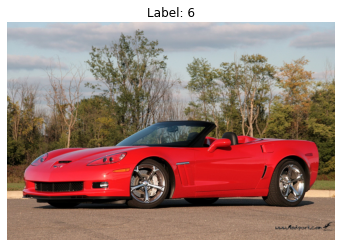

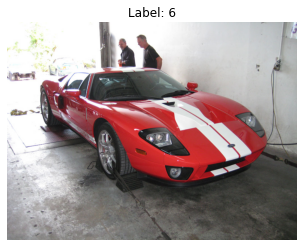

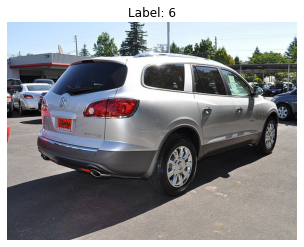

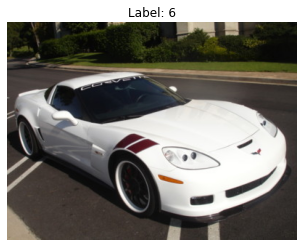

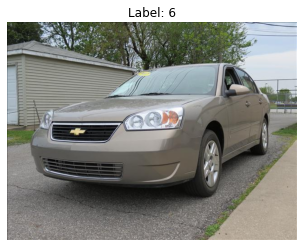

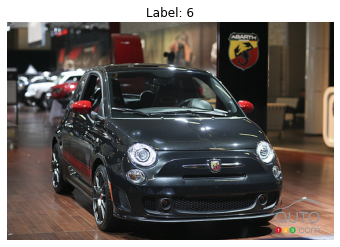

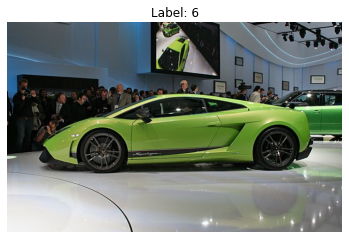

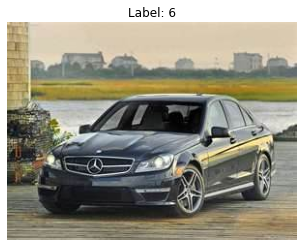

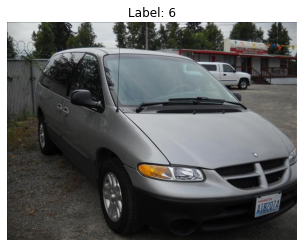

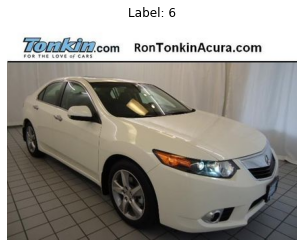

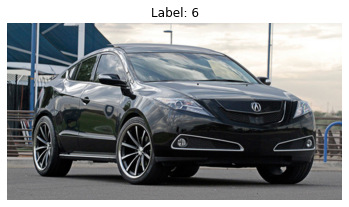

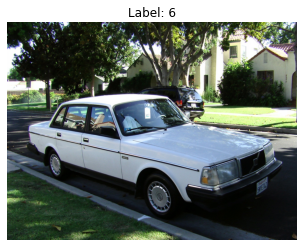

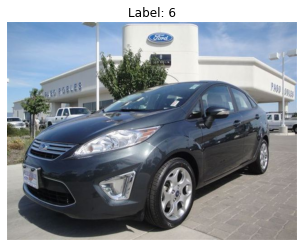

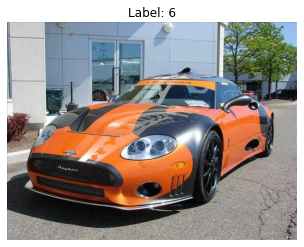

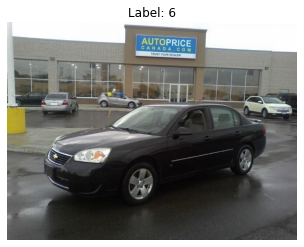

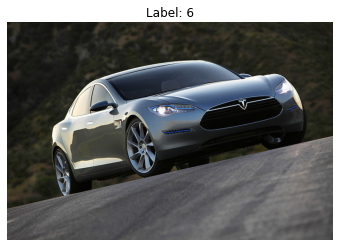

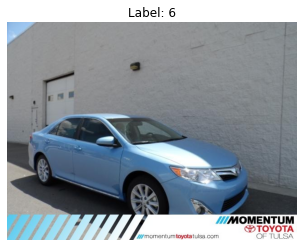

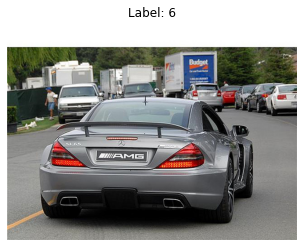

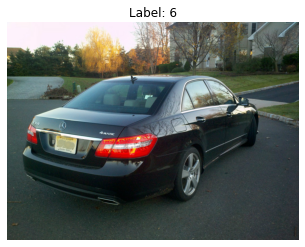

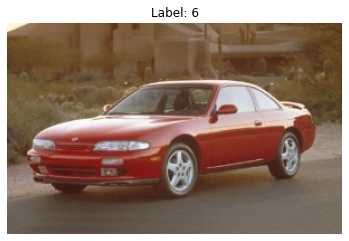

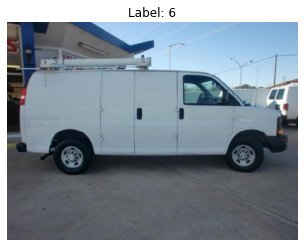

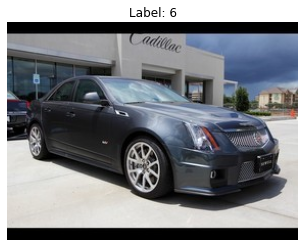

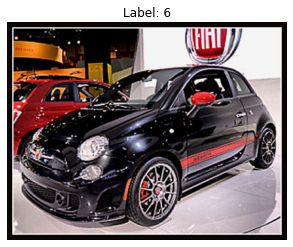

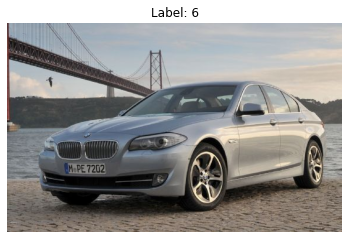

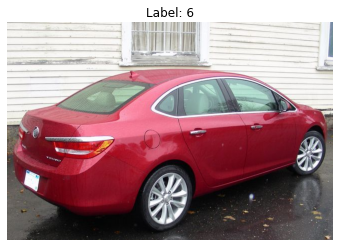

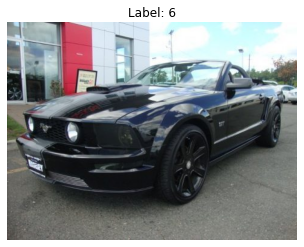

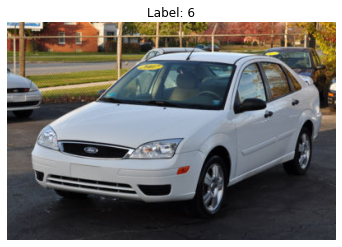

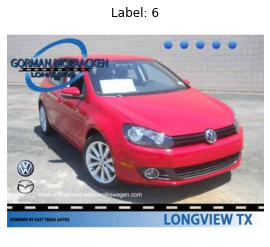

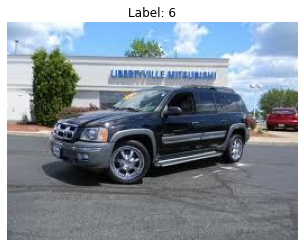

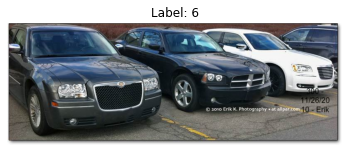

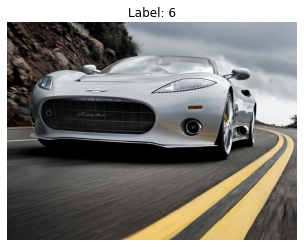

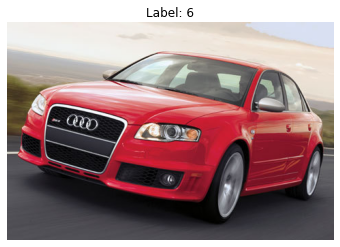

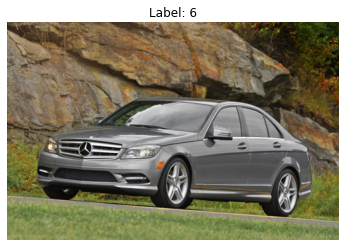

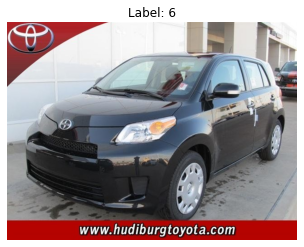

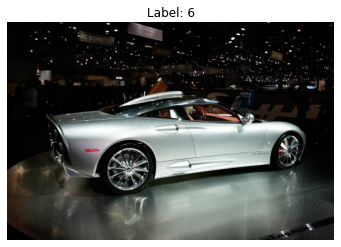

In [33]:
for idx, row in train_class_5.iterrows():
    img_path = row['file']
    label = row['label']
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Image at {img_path} could not be loaded.")


In [35]:
from scipy.io import loadmat

# Załadowanie pliku .mat
mat = loadmat('cars_annos.mat')

# Wyciągnięcie nazw klas
class_names = mat['class_names'][0]

# Konwersja z formatu numpy array do listy stringów
class_names = [str(array[0]) for array in class_names]

# Wyświetlenie kilku pierwszych nazw klas
print(class_names[:5])


['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012']


In [37]:
from scipy.io import loadmat

# Wczytanie pliku .mat
mat_data = loadmat('cars_annos.mat')

# Wyświetlenie kluczy w słowniku mat_data
print("Klucze w słowniku mat_data:", mat_data.keys())

for key in mat_data.keys():
    print(f"Struktura dla klucza '{key}':")
    print(mat_data[key])
    print("--------------------------------------------------")


Klucze w słowniku mat_data: dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])
Struktura dla klucza '__header__':
b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Feb 28 19:34:55 2015'
--------------------------------------------------
Struktura dla klucza '__version__':
1.0
--------------------------------------------------
Struktura dla klucza '__globals__':
[]
--------------------------------------------------
Struktura dla klucza 'annotations':
[[(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8))
  (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8))
  (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=u